<a href="https://colab.research.google.com/github/yghebre6/Swift-for-TensorFlow/blob/main/Inception_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Inception-v1 in S4TF

## Configure imports

In [ ]:
%install '.package(url: "https://github.com/tensorflow/swift-models", .branch("tensorflow-0.11"))' Datasets
print("\u{001B}[2J")

In [ ]:
import Datasets
import ImageClassificationModels
import TensorFlow
import Python
import Foundation

In [ ]:
%include "EnableIPythonDisplay.swift"
IPythonDisplay.shell.enable_matplotlib("inline")

let plt = Python.import("matplotlib.pyplot")
let np  = Python.import("numpy")
let subprocess = Python.import("subprocess")
let glob = Python.import("glob")
let pil = Python.import("PIL")
let h5py = Python.import("h5py")
let path = Python.import("os.path")
let tf = Python.import("tensorflow")

2020-11-29 23:01:54.939420: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1


## Model

### Local-response regularization

In [ ]:
public struct LRN: ParameterlessLayer {
    public typealias TangentVector = EmptyTangentVector

    @differentiable
    public func callAsFunction(_ input: Tensor<Float>) -> Tensor<Float> {
        return localResponseNorm(input)
    }
}

func localResponseNorm<T : TensorFlowFloatingPoint>(_ input: Tensor<T>) -> Tensor<T> {
    return _Raw.lRN(input, depthRadius:5, bias:1, alpha:0.0001, beta:0.75)
}

@derivative(of: localResponseNorm)
func vjpLocalResponseNorm<T : TensorFlowFloatingPoint>(_ input: Tensor<T>) -> (value: Tensor<T>, pullback: (Tensor<T>) -> (Tensor<T>)) {
    let value = _Raw.lRN(input, depthRadius:5, bias:1, alpha:0.0001, beta:0.75)
    return (value: value, pullback: { v in
        _Raw.lRNGrad(inputGrads: v, inputImage: input, outputImage: value, depthRadius: 5, bias: 1, alpha: 0.0001, beta: 0.75)
    })
}

### Inception-v1

Architecture as described here https://arxiv.org/pdf/1409.4842.pdf

In [ ]:
struct InceptionV1: Layer {

    var conv1 = Conv2D<Float>(filterShape: (7, 7, 3, 64), strides: (2, 2), padding: .valid, activation: relu, useBias: false)
    var max_pool1 = MaxPool2D<Float>(poolSize: (3, 3), strides: (2, 2), padding: .valid)
    var lrn1 = LRN()

    var conv2 = Conv2D<Float>(filterShape: (1, 1, 64, 64), strides: (1, 1), padding: .same, activation: relu, useBias: false)
    var conv3 = Conv2D<Float>(filterShape: (3, 3, 64, 192), strides: (1, 1), padding: .same, activation: relu, useBias: false)
    var lrn2 = LRN()
    var max_pool2 = MaxPool2D<Float>(poolSize: (3, 3), strides: (2, 2), padding: .valid)
    
    var inception_3a_1x1 = Conv2D<Float>(filterShape: (1, 1, 192, 64), strides: (1, 1), padding: .same, activation: relu, useBias: false)
    var inception_3a_3x3_reduce = Conv2D<Float>(filterShape: (1, 1, 192, 96), strides: (1, 1), padding: .same, activation: relu, useBias: false)
    var inception_3a_3x3 = Conv2D<Float>(filterShape: (3, 3, 96, 128), strides: (1, 1), padding: .same, activation: relu, useBias: false)
    var inception_3a_5x5_reduce = Conv2D<Float>(filterShape: (1, 1, 192, 16), strides: (1, 1), padding: .same, activation: relu, useBias: false)
    var inception_3a_5x5 = Conv2D<Float>(filterShape: (5, 5, 16, 32), strides: (1, 1), padding: .same, activation: relu, useBias: false)
    var inception_3a_pool = MaxPool2D<Float>(poolSize: (3, 3), strides: (1, 1), padding: .same)
    var inception_3a_pool_proj = Conv2D<Float>(filterShape: (1, 1, 192, 32), strides: (1, 1), padding: .same, activation: relu, useBias: false)

    var inception_3b_1x1 = Conv2D<Float>(filterShape: (1, 1, 256, 128), strides: (1, 1), padding: .same, activation: relu, useBias: false)
    var inception_3b_3x3_reduce = Conv2D<Float>(filterShape: (1, 1, 256, 128), strides: (1, 1), padding: .same, activation: relu, useBias: false)
    var inception_3b_3x3 = Conv2D<Float>(filterShape: (3, 3, 128, 192), strides: (1, 1), padding: .same, activation: relu, useBias: false)
    var inception_3b_5x5_reduce = Conv2D<Float>(filterShape: (1, 1, 256, 32), strides: (1, 1), padding: .same, activation: relu, useBias: false)
    var inception_3b_5x5 = Conv2D<Float>(filterShape: (5, 5, 32, 96), strides: (1, 1), padding: .same, activation: relu, useBias: false)
    var inception_3b_pool = MaxPool2D<Float>(poolSize: (3, 3), strides: (1, 1), padding: .same)
    var inception_3b_pool_proj = Conv2D<Float>(filterShape: (1, 1, 256, 64), strides: (1, 1), padding: .same, activation: relu, useBias: false)
    
    var max_pool3 = MaxPool2D<Float>(poolSize: (3, 3), strides: (2, 2), padding: .valid)
    
    var inception_4a_1x1 = Conv2D<Float>(filterShape: (1, 1, 480, 192), strides: (1, 1), padding: .same, activation: relu, useBias: false)
    var inception_4a_3x3_reduce = Conv2D<Float>(filterShape: (1, 1, 480, 96), strides: (1, 1), padding: .same, activation: relu, useBias: false)
    var inception_4a_3x3 = Conv2D<Float>(filterShape: (3, 3, 96, 208), strides: (1, 1), padding: .same, activation: relu, useBias: false)
    var inception_4a_5x5_reduce = Conv2D<Float>(filterShape: (1, 1, 480, 16), strides: (1, 1), padding: .same, activation: relu, useBias: false)
    var inception_4a_5x5 = Conv2D<Float>(filterShape: (5, 5, 16, 48), strides: (1, 1), padding: .same, activation: relu, useBias: false)
    var inception_4a_pool = MaxPool2D<Float>(poolSize: (3, 3), strides: (1, 1), padding: .same)
    var inception_4a_pool_proj = Conv2D<Float>(filterShape: (1, 1, 480, 64), strides: (1, 1), padding: .same, activation: relu, useBias: false)
    
    var aux_class1_avg_pool = AvgPool2D<Float>(poolSize: (5, 5), strides: (3, 3), padding: .valid)
    var aux_class1_conv = Conv2D<Float>(filterShape: (1, 1, 512, 128), strides: (1, 1), padding: .same, activation: relu, useBias: false)
    var aux_class1_flatten = Flatten<Float>()
    var aux_class1_fc = Dense<Float>(inputSize: 1152, outputSize: 1024, activation: relu)
    var aux_class1_dropout = Dropout<Float>(probability: 0.7)
    var aux_class1 = Dense<Float>(inputSize: 1024, outputSize: 10)

    var inception_4b_1x1 = Conv2D<Float>(filterShape: (1, 1, 512, 160), strides: (1, 1), padding: .same, activation: relu, useBias: false)
    var inception_4b_3x3_reduce = Conv2D<Float>(filterShape: (1, 1, 512, 112), strides: (1, 1), padding: .same, activation: relu, useBias: false)
    var inception_4b_3x3 = Conv2D<Float>(filterShape: (3, 3, 112, 224), strides: (1, 1), padding: .same, activation: relu, useBias: false)
    var inception_4b_5x5_reduce = Conv2D<Float>(filterShape: (1, 1, 512, 24), strides: (1, 1), padding: .same, activation: relu, useBias: false)
    var inception_4b_5x5 = Conv2D<Float>(filterShape: (5, 5, 24, 64), strides: (1, 1), padding: .same, activation: relu, useBias: false)
    var inception_4b_pool = MaxPool2D<Float>(poolSize: (3, 3), strides: (1, 1), padding: .same)
    var inception_4b_pool_proj = Conv2D<Float>(filterShape: (1, 1, 512, 64), strides: (1, 1), padding: .same, activation: relu, useBias: false)

    var inception_4c_1x1 = Conv2D<Float>(filterShape: (1, 1, 512, 128), strides: (1, 1), padding: .same, activation: relu, useBias: false)
    var inception_4c_3x3_reduce = Conv2D<Float>(filterShape: (1, 1, 512, 128), strides: (1, 1), padding: .same, activation: relu, useBias: false)
    var inception_4c_3x3 = Conv2D<Float>(filterShape: (3, 3, 128, 256), strides: (1, 1), padding: .same, activation: relu, useBias: false)
    var inception_4c_5x5_reduce = Conv2D<Float>(filterShape: (1, 1, 512, 24), strides: (1, 1), padding: .same, activation: relu, useBias: false)
    var inception_4c_5x5 = Conv2D<Float>(filterShape: (5, 5, 24, 64), strides: (1, 1), padding: .same, activation: relu, useBias: false)
    var inception_4c_pool = MaxPool2D<Float>(poolSize: (3, 3), strides: (1, 1), padding: .same)
    var inception_4c_pool_proj = Conv2D<Float>(filterShape: (1, 1, 512, 64), strides: (1, 1), padding: .same, activation: relu, useBias: false)

    var inception_4d_1x1 = Conv2D<Float>(filterShape: (1, 1, 512, 112), strides: (1, 1), padding: .same, activation: relu, useBias: false)
    var inception_4d_3x3_reduce = Conv2D<Float>(filterShape: (1, 1, 512, 144), strides: (1, 1), padding: .same, activation: relu, useBias: false)
    var inception_4d_3x3 = Conv2D<Float>(filterShape: (3, 3, 144, 288), strides: (1, 1), padding: .same, activation: relu, useBias: false)
    var inception_4d_5x5_reduce = Conv2D<Float>(filterShape: (1, 1, 512, 32), strides: (1, 1), padding: .same, activation: relu, useBias: false)
    var inception_4d_5x5 = Conv2D<Float>(filterShape: (5, 5, 32, 64), strides: (1, 1), padding: .same, activation: relu, useBias: false)
    var inception_4d_pool = MaxPool2D<Float>(poolSize: (3, 3), strides: (1, 1), padding: .same)
    var inception_4d_pool_proj = Conv2D<Float>(filterShape: (1, 1, 512, 64), strides: (1, 1), padding: .same, activation: relu, useBias: false)

    var aux_class2_avg_pool = AvgPool2D<Float>(poolSize: (5, 5), strides: (3, 3), padding: .valid)
    var aux_class2_conv = Conv2D<Float>(filterShape: (1, 1, 528, 128), strides: (1, 1), padding: .same, activation: relu, useBias: false)
    var aux_class2_flatten = Flatten<Float>()
    var aux_class2_fc = Dense<Float>(inputSize: 1152, outputSize: 1024, activation: relu)
    var aux_class2_dropout = Dropout<Float>(probability: 0.7)
    var aux_class2 = Dense<Float>(inputSize: 1024, outputSize: 10)

    var inception_4e_1x1 = Conv2D<Float>(filterShape: (1, 1, 528, 256), strides: (1, 1), padding: .same, activation: relu, useBias: false)
    var inception_4e_3x3_reduce = Conv2D<Float>(filterShape: (1, 1, 528, 160), strides: (1, 1), padding: .same, activation: relu, useBias: false)
    var inception_4e_3x3 = Conv2D<Float>(filterShape: (3, 3, 160, 320), strides: (1, 1), padding: .same, activation: relu, useBias: false)
    var inception_4e_5x5_reduce = Conv2D<Float>(filterShape: (1, 1, 528, 32), strides: (1, 1), padding: .same, activation: relu, useBias: false)
    var inception_4e_5x5 = Conv2D<Float>(filterShape: (5, 5, 32, 128), strides: (1, 1), padding: .same, activation: relu, useBias: false)
    var inception_4e_pool = MaxPool2D<Float>(poolSize: (3, 3), strides: (1, 1), padding: .same)
    var inception_4e_pool_proj = Conv2D<Float>(filterShape: (1, 1, 528, 128), strides: (1, 1), padding: .same, activation: relu, useBias: false)

    var max_pool4 = MaxPool2D<Float>(poolSize: (3, 3), strides: (2, 2), padding: .valid)

    var inception_5a_1x1 = Conv2D<Float>(filterShape: (1, 1, 832, 256), strides: (1, 1), padding: .same, activation: relu, useBias: false)
    var inception_5a_3x3_reduce = Conv2D<Float>(filterShape: (1, 1, 832, 160), strides: (1, 1), padding: .same, activation: relu, useBias: false)
    var inception_5a_3x3 = Conv2D<Float>(filterShape: (3, 3, 160, 320), strides: (1, 1), padding: .same, activation: relu, useBias: false)
    var inception_5a_5x5_reduce = Conv2D<Float>(filterShape: (1, 1, 832, 32), strides: (1, 1), padding: .same, activation: relu, useBias: false)
    var inception_5a_5x5 = Conv2D<Float>(filterShape: (5, 5, 32, 128), strides: (1, 1), padding: .same, activation: relu, useBias: false)
    var inception_5a_pool = MaxPool2D<Float>(poolSize: (3, 3), strides: (1, 1), padding: .same)
    var inception_5a_pool_proj = Conv2D<Float>(filterShape: (1, 1, 832, 128), strides: (1, 1), padding: .same, activation: relu, useBias: false)

    var inception_5b_1x1 = Conv2D<Float>(filterShape: (1, 1, 832, 384), strides: (1, 1), padding: .same, activation: relu, useBias: false)
    var inception_5b_3x3_reduce = Conv2D<Float>(filterShape: (1, 1, 832, 192), strides: (1, 1), padding: .same, activation: relu, useBias: false)
    var inception_5b_3x3 = Conv2D<Float>(filterShape: (3, 3, 192, 384), strides: (1, 1), padding: .same, activation: relu, useBias: false)
    var inception_5b_5x5_reduce = Conv2D<Float>(filterShape: (1, 1, 832, 48), strides: (1, 1), padding: .same, activation: relu, useBias: false)
    var inception_5b_5x5 = Conv2D<Float>(filterShape: (5, 5, 48, 128), strides: (1, 1), padding: .same, activation: relu, useBias: false)
    var inception_5b_pool = MaxPool2D<Float>(poolSize: (3, 3), strides: (1, 1), padding: .same)
    var inception_5b_pool_proj = Conv2D<Float>(filterShape: (1, 1, 832, 128), strides: (1, 1), padding: .same, activation: relu, useBias: false)

    var avg_pool = AvgPool2D<Float>(poolSize: (5, 5), strides: (1, 1), padding: .valid)
    var flatten = Flatten<Float>()
    var dropout = Dropout<Float>(probability: 0.4)
    var fc = Dense<Float>(inputSize: 1024, outputSize: 10)

    @differentiable
    func callAsFunction(_ input: Tensor<Float>) -> Tensor<Float> {
        var output = conv1(input)
        output = max_pool1(output)
        output = lrn1(output)

        output = conv2(output)
        output = conv3(output)
        output = lrn2(output)
        output = max_pool2(output)

        var output_1x1 = inception_3a_1x1(output)
        var output_3x3 = inception_3a_3x3_reduce(output)
        output_3x3 = inception_3a_3x3(output_3x3)
        var output_5x5 = inception_3a_5x5_reduce(output)
        output_5x5 = inception_3a_5x5(output_5x5)
        var output_pool = inception_3a_pool(output)
        output_pool = inception_3a_pool_proj(output_pool)
        output = Tensor<Float>(concatenating: [output_1x1, output_3x3, output_5x5, output_pool], alongAxis: 3)
        
        output_1x1 = inception_3b_1x1(output)
        output_3x3 = inception_3b_3x3_reduce(output)
        output_3x3 = inception_3b_3x3(output_3x3)
        output_5x5 = inception_3b_5x5_reduce(output)
        output_5x5 = inception_3b_5x5(output_5x5)
        output_pool = inception_3b_pool(output)
        output_pool = inception_3b_pool_proj(output_pool)
        output = Tensor<Float>(concatenating: [output_1x1, output_3x3, output_5x5, output_pool], alongAxis: 3)

        output = max_pool3(output)
        
        output_1x1 = inception_4a_1x1(output)
        output_3x3 = inception_4a_3x3_reduce(output)
        output_3x3 = inception_4a_3x3(output_3x3)
        output_5x5 = inception_4a_5x5_reduce(output)
        output_5x5 = inception_4a_5x5(output_5x5)
        output_pool = inception_4a_pool(output)
        output_pool = inception_4a_pool_proj(output_pool)
        output = Tensor<Float>(concatenating: [output_1x1, output_3x3, output_5x5, output_pool], alongAxis: 3)

        var aux_class1_output = aux_class1_avg_pool(output)
        aux_class1_output = aux_class1_conv(aux_class1_output)
        aux_class1_output = aux_class1_flatten(aux_class1_output)
        aux_class1_output = aux_class1_fc(aux_class1_output)
        aux_class1_output = aux_class1_dropout(aux_class1_output)
        aux_class1_output = aux_class1(aux_class1_output)

        output_1x1 = inception_4b_1x1(output)
        output_3x3 = inception_4b_3x3_reduce(output)
        output_3x3 = inception_4b_3x3(output_3x3)
        output_5x5 = inception_4b_5x5_reduce(output)
        output_5x5 = inception_4b_5x5(output_5x5)
        output_pool = inception_4b_pool(output)
        output_pool = inception_4b_pool_proj(output_pool)
        output = Tensor<Float>(concatenating: [output_1x1, output_3x3, output_5x5, output_pool], alongAxis: 3)

        output_1x1 = inception_4c_1x1(output)
        output_3x3 = inception_4c_3x3_reduce(output)
        output_3x3 = inception_4c_3x3(output_3x3)
        output_5x5 = inception_4c_5x5_reduce(output)
        output_5x5 = inception_4c_5x5(output_5x5)
        output_pool = inception_4c_pool(output)
        output_pool = inception_4c_pool_proj(output_pool)
        output = Tensor<Float>(concatenating: [output_1x1, output_3x3, output_5x5, output_pool], alongAxis: 3)

        output_1x1 = inception_4d_1x1(output)
        output_3x3 = inception_4d_3x3_reduce(output)
        output_3x3 = inception_4d_3x3(output_3x3)
        output_5x5 = inception_4d_5x5_reduce(output)
        output_5x5 = inception_4d_5x5(output_5x5)
        output_pool = inception_4d_pool(output)
        output_pool = inception_4d_pool_proj(output_pool)
        output = Tensor<Float>(concatenating: [output_1x1, output_3x3, output_5x5, output_pool], alongAxis: 3)

        var aux_class2_output = aux_class2_avg_pool(output)
        aux_class2_output = aux_class2_conv(aux_class2_output)
        aux_class2_output = aux_class2_flatten(aux_class2_output)
        aux_class2_output = aux_class2_fc(aux_class2_output)
        aux_class2_output = aux_class2_dropout(aux_class2_output)
        aux_class2_output = aux_class2(aux_class2_output)

        output_1x1 = inception_4e_1x1(output)
        output_3x3 = inception_4e_3x3_reduce(output)
        output_3x3 = inception_4e_3x3(output_3x3)
        output_5x5 = inception_4e_5x5_reduce(output)
        output_5x5 = inception_4e_5x5(output_5x5)
        output_pool = inception_4e_pool(output)
        output_pool = inception_4e_pool_proj(output_pool)
        output = Tensor<Float>(concatenating: [output_1x1, output_3x3, output_5x5, output_pool], alongAxis: 3)

        output = max_pool4(output)

        output_1x1 = inception_5a_1x1(output)
        output_3x3 = inception_5a_3x3_reduce(output)
        output_3x3 = inception_5a_3x3(output_3x3)
        output_5x5 = inception_5a_5x5_reduce(output)
        output_5x5 = inception_5a_5x5(output_5x5)
        output_pool = inception_5a_pool(output)
        output_pool = inception_5a_pool_proj(output_pool)
        output = Tensor<Float>(concatenating: [output_1x1, output_3x3, output_5x5, output_pool], alongAxis: 3)

        output_1x1 = inception_5b_1x1(output)
        output_3x3 = inception_5b_3x3_reduce(output)
        output_3x3 = inception_5b_3x3(output_3x3)
        output_5x5 = inception_5b_5x5_reduce(output)
        output_5x5 = inception_5b_5x5(output_5x5)
        output_pool = inception_5b_pool(output)
        output_pool = inception_5b_pool_proj(output_pool)
        output = Tensor<Float>(concatenating: [output_1x1, output_3x3, output_5x5, output_pool], alongAxis: 3)
        
        output = avg_pool(output)
        output = flatten(output)
        output = dropout(output)
        output = fc(output)

        if (Context.local.learningPhase == .training) {
          return 0.3 * aux_class1_output + 0.3 * aux_class2_output + output
        } else {
          return output
        }
    }
}

### L2 loss

In [ ]:
struct L2 {
    var l2_loss = Tensor<Float>(0, on: Device.default)
    var inception_v1: InceptionV1

    init(on device: Device = Device.default, inception_v1: InceptionV1) {
        l2_loss = Tensor<Float>(0, on: device)
        self.inception_v1 = inception_v1
    }

    mutating func loss() -> Tensor<Float> {
      var weight = inception_v1.conv1.filter
      l2_loss += (weight * weight).sum()

      weight = inception_v1.conv2.filter
      l2_loss += (weight * weight).sum()
      weight = inception_v1.conv3.filter
      l2_loss += (weight * weight).sum()

      weight = inception_v1.inception_3a_1x1.filter
      l2_loss += (weight * weight).sum()
      weight = inception_v1.inception_3a_3x3_reduce.filter
      l2_loss += (weight * weight).sum()
      weight = inception_v1.inception_3a_3x3.filter
      l2_loss += (weight * weight).sum()
      weight = inception_v1.inception_3a_5x5_reduce.filter
      l2_loss += (weight * weight).sum()
      weight = inception_v1.inception_3a_5x5.filter
      l2_loss += (weight * weight).sum()
      weight = inception_v1.inception_3a_pool_proj.filter
      l2_loss += (weight * weight).sum()

      weight = inception_v1.inception_3b_1x1.filter
      l2_loss += (weight * weight).sum()
      weight = inception_v1.inception_3b_3x3_reduce.filter
      l2_loss += (weight * weight).sum()
      weight = inception_v1.inception_3b_3x3.filter
      l2_loss += (weight * weight).sum()
      weight = inception_v1.inception_3b_5x5_reduce.filter
      l2_loss += (weight * weight).sum()
      weight = inception_v1.inception_3b_5x5.filter
      l2_loss += (weight * weight).sum()
      weight = inception_v1.inception_3b_pool_proj.filter
      l2_loss += (weight * weight).sum()

      weight = inception_v1.inception_4a_1x1.filter
      l2_loss += (weight * weight).sum()
      weight = inception_v1.inception_4a_3x3_reduce.filter
      l2_loss += (weight * weight).sum()
      weight = inception_v1.inception_4a_3x3.filter
      l2_loss += (weight * weight).sum()
      weight = inception_v1.inception_4a_5x5_reduce.filter
      l2_loss += (weight * weight).sum()
      weight = inception_v1.inception_4a_5x5.filter
      l2_loss += (weight * weight).sum()
      weight = inception_v1.inception_4a_pool_proj.filter
      l2_loss += (weight * weight).sum()

      weight = inception_v1.aux_class1_conv.filter
      l2_loss += (weight * weight).sum()
      weight = inception_v1.aux_class1_fc.weight
      l2_loss += (weight * weight).sum()
      weight = inception_v1.aux_class1_fc.weight
      l2_loss += (weight * weight).sum()

      weight = inception_v1.inception_4b_1x1.filter
      l2_loss += (weight * weight).sum()
      weight = inception_v1.inception_4b_3x3_reduce.filter
      l2_loss += (weight * weight).sum()
      weight = inception_v1.inception_4b_3x3.filter
      l2_loss += (weight * weight).sum()
      weight = inception_v1.inception_4b_5x5_reduce.filter
      l2_loss += (weight * weight).sum()
      weight = inception_v1.inception_4b_5x5.filter
      l2_loss += (weight * weight).sum()
      weight = inception_v1.inception_4b_pool_proj.filter
      l2_loss += (weight * weight).sum()

      weight = inception_v1.inception_4c_1x1.filter
      l2_loss += (weight * weight).sum()
      weight = inception_v1.inception_4c_3x3_reduce.filter
      l2_loss += (weight * weight).sum()
      weight = inception_v1.inception_4c_3x3.filter
      l2_loss += (weight * weight).sum()
      weight = inception_v1.inception_4c_5x5_reduce.filter
      l2_loss += (weight * weight).sum()
      weight = inception_v1.inception_4c_5x5.filter
      l2_loss += (weight * weight).sum()
      weight = inception_v1.inception_4c_pool_proj.filter
      l2_loss += (weight * weight).sum()

      weight = inception_v1.inception_4d_1x1.filter
      l2_loss += (weight * weight).sum()
      weight = inception_v1.inception_4d_3x3_reduce.filter
      l2_loss += (weight * weight).sum()
      weight = inception_v1.inception_4d_3x3.filter
      l2_loss += (weight * weight).sum()
      weight = inception_v1.inception_4d_5x5_reduce.filter
      l2_loss += (weight * weight).sum()
      weight = inception_v1.inception_4d_5x5.filter
      l2_loss += (weight * weight).sum()
      weight = inception_v1.inception_4d_pool_proj.filter
      l2_loss += (weight * weight).sum()

      weight = inception_v1.aux_class2_conv.filter
      l2_loss += (weight * weight).sum()
      weight = inception_v1.aux_class2_fc.weight
      l2_loss += (weight * weight).sum()
      weight = inception_v1.aux_class2_fc.weight
      l2_loss += (weight * weight).sum()

      weight = inception_v1.inception_4e_1x1.filter
      l2_loss += (weight * weight).sum()
      weight = inception_v1.inception_4e_3x3_reduce.filter
      l2_loss += (weight * weight).sum()
      weight = inception_v1.inception_4e_3x3.filter
      l2_loss += (weight * weight).sum()
      weight = inception_v1.inception_4e_5x5_reduce.filter
      l2_loss += (weight * weight).sum()
      weight = inception_v1.inception_4e_5x5.filter
      l2_loss += (weight * weight).sum()
      weight = inception_v1.inception_4e_pool_proj.filter
      l2_loss += (weight * weight).sum()

      weight = inception_v1.inception_5a_1x1.filter
      l2_loss += (weight * weight).sum()
      weight = inception_v1.inception_5a_3x3_reduce.filter
      l2_loss += (weight * weight).sum()
      weight = inception_v1.inception_5a_3x3.filter
      l2_loss += (weight * weight).sum()
      weight = inception_v1.inception_5a_5x5_reduce.filter
      l2_loss += (weight * weight).sum()
      weight = inception_v1.inception_5a_5x5.filter
      l2_loss += (weight * weight).sum()
      weight = inception_v1.inception_5a_pool_proj.filter
      l2_loss += (weight * weight).sum()

      weight = inception_v1.inception_5b_1x1.filter
      l2_loss += (weight * weight).sum()
      weight = inception_v1.inception_5b_3x3_reduce.filter
      l2_loss += (weight * weight).sum()
      weight = inception_v1.inception_5b_3x3.filter
      l2_loss += (weight * weight).sum()
      weight = inception_v1.inception_5b_5x5_reduce.filter
      l2_loss += (weight * weight).sum()
      weight = inception_v1.inception_5b_5x5.filter
      l2_loss += (weight * weight).sum()
      weight = inception_v1.inception_5b_pool_proj.filter
      l2_loss += (weight * weight).sum()
      
      weight = inception_v1.fc.weight
      l2_loss += (weight * weight).sum()

      return l2_loss
    }
}

## Training + Inference

In [ ]:
struct Statistics {
    var device: Device = Device.default
    var epochs: Int = 0
    var avgEpochTrainTime: Double = 0
    var correctGuessCount = Tensor<Int32>(0, on: Device.default)
    var totalGuessCount = Tensor<Int32>(0, on: Device.default)
    var totalLoss = Tensor<Float>(0, on: Device.default)
    var batches: Int = 0
    var accuracy: Float { 
        Float(correctGuessCount.scalarized()) / Float(totalGuessCount.scalarized()) * 100 
    } 
    var averageLoss: Float { totalLoss.scalarized() / Float(batches) }

    var correctGuessCounts = Tensor<Int32>(0, on: Device.default)
    var totalGuessCounts = Tensor<Int32>(0, on: Device.default)
    var totalLosses = Tensor<Float>(0, on: Device.default)
    var accuracies = Tensor<Float>(0, on: Device.default)
    var averageLosses = Tensor<Float>(0, on: Device.default)

    init(on device: Device, epochs: Int) {
      self.device = device
      self.epochs = epochs
      correctGuessCount = Tensor<Int32>(0, on: device)
      totalGuessCount = Tensor<Int32>(0, on: device)
      totalLoss = Tensor<Float>(0, on: device)

      correctGuessCounts = Tensor<Int32>(zeros: [epochs], on: device)
      totalGuessCounts = Tensor<Int32>(zeros: [epochs], on: device)
      totalLosses = Tensor<Float>(zeros: [epochs], on: device)
      accuracies = Tensor<Float>(zeros: [epochs], on: device)
      averageLosses = Tensor<Float>(zeros: [epochs], on: device)
    }

    mutating func update(logits: Tensor<Float>, labels: Tensor<Float>, loss: Tensor<Float>) {
      let correct = logits.argmax(squeezingAxis: 1) .== labels.argmax(squeezingAxis: 1)
      correctGuessCount += Tensor<Int32>(correct).sum()
      totalGuessCount += Int32(labels.shape[0])
      totalLoss += loss
      batches += 1
    }

    mutating func add(epoch: Int, trainTime: Double = 0) {
      avgEpochTrainTime += trainTime / Double(epochs)
      correctGuessCounts[epoch] = Tensor<Int32>(correctGuessCount.scalar!, on:device)
      totalGuessCounts[epoch] = Tensor<Int32>(totalGuessCount.scalar!, on:device)
      totalLosses[epoch] = Tensor<Float>(totalLoss.scalar!, on:device)
      accuracies[epoch] = Tensor<Float>(accuracy, on:device)
      averageLosses[epoch] = Tensor<Float>(averageLoss, on:device)

      correctGuessCount = Tensor<Int32>(0, on: device)
      totalGuessCount = Tensor<Int32>(0, on: device)
      totalLoss = Tensor<Float>(0, on: device)
      batches = 0
    }
}

### Configuration/Import dataset

In [ ]:
let device = Device.defaultXLA
var inception_v1 = InceptionV1()
inception_v1.move(to: device)
var optimizer = SGD(for: inception_v1, learningRate: 0.045, momentum: 0.9)
optimizer = SGD(copying: optimizer, to: device)
let reg: Float = 0.00004

let epochCount = 100
let batchSize = 32
let dataset = Imagenette(batchSize: batchSize, on: Device.default)

2020-11-29 23:07:25.922561: I tensorflow/compiler/xla/xla_client/xrt_local_service.cc:54] Peer localservice 1 {localhost:30758}
2020-11-29 23:07:25.926747: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2020-11-29 23:07:25.963331: I tensorflow/core/platform/profile_utils/cpu_utils.cc:104] CPU Frequency: 2000175000 Hz
2020-11-29 23:07:25.963971: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x2d84260 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2020-11-29 23:07:25.964004: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2020-11-29 23:07:26.042370: I tensorflow/stream_executor/platform/d

In [ ]:
print("Beginning training...")
var trainStats = Statistics(on: device, epochs: epochCount)
var testStats = Statistics(on: device, epochs: epochCount)
var l2 = L2(on: device, inception_v1: inception_v1)
for (epoch, batches) in dataset.training.prefix(epochCount).enumerated() {
    let start = Date()

    Context.local.learningPhase = .training
    for batch in batches {
        let (eagerImages, eagerLabels) = (batch.data, batch.label)
        let images = Tensor(copying: Tensor<Float>(eagerImages), to: device)
        let oneHotLabels = Tensor<Float>(Tensor<Int32>(oneHotAtIndices: eagerLabels, depth: 10))
        let labels = Tensor(copying: oneHotLabels, to: device)
        var 𝛁model = TensorFlow.gradient(at: inception_v1) { inception_v1 -> Tensor<Float> in
            let ŷ = inception_v1(images)
            let loss = softmaxCrossEntropy(logits: ŷ, probabilities: labels)
            trainStats.update(logits: ŷ, labels: labels, loss: loss)
            return loss + reg * l2.loss()
        }
        optimizer.update(&inception_v1, along: 𝛁model)
        LazyTensorBarrier()
    }
    let end = Date()

    Context.local.learningPhase = .inference
    for batch in dataset.validation {
        let (eagerImages, eagerLabels) = (batch.data, batch.label)
        let images = Tensor(copying: Tensor<Float>(eagerImages), to: device)
        let oneHotLabels = Tensor<Float>(Tensor<Int32>(oneHotAtIndices: eagerLabels, depth: 10))
        let labels = Tensor(copying: oneHotLabels, to: device)
        let ŷ = inception_v1(images)
        let loss = softmaxCrossEntropy(logits: ŷ, probabilities: labels)
        LazyTensorBarrier()
        testStats.update(logits: ŷ, labels: labels, loss: loss)
    }

    if (epoch % 8 == 1) {
      optimizer.learningRate = optimizer.learningRate * 0.96
    }

    print(
        """
        [Epoch \(epoch)] \
        Training Loss: \(String(format: "%.3f", trainStats.averageLoss)), \
        Training Accuracy: \(trainStats.correctGuessCount)/\(trainStats.totalGuessCount) \
        (\(String(format: "%.1f", trainStats.accuracy))%), \
        Test Loss: \(String(format: "%.3f", testStats.averageLoss)), \
        Test Accuracy: \(testStats.correctGuessCount)/\(testStats.totalGuessCount) \
        (\(String(format: "%.1f", testStats.accuracy))%) \
        seconds per epoch: \(String(format: "%.1f", Date().timeIntervalSince(start)))
        """)

    let trainTime = Date().timeIntervalSince(start) - Date().timeIntervalSince(end)
    trainStats.add(epoch: epoch, trainTime: trainTime)
    testStats.add(epoch: epoch)
}

Beginning training...
2020-11-29 23:08:06.540764: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2020-11-29 23:08:06.749251: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudnn.so.7
[Epoch 0] Training Loss: 2.183, Training Accuracy: 2492/12864 (19.4%), Test Loss: 2.314, Test Accuracy: 55/500 (11.0%) seconds per epoch: 716.8
[Epoch 1] Training Loss: 1.016, Training Accuracy: 3643/12864 (28.3%), Test Loss: 1.147, Test Accuracy: 56/500 (11.2%) seconds per epoch: 705.3
[Epoch 2] Training Loss: 0.610, Training Accuracy: 4789/12864 (37.2%), Test Loss: 0.767, Test Accuracy: 55/500 (11.0%) seconds per epoch: 709.6
[Epoch 3] Training Loss: 0.423, Training Accuracy: 5500/12864 (42.8%), Test Loss: 0.568, Test Accuracy: 67/500 (13.4%) seconds per epoch: 593.7
[Epoch 4] Training Loss: 0.306, Training Accuracy: 6364/12864 (49.5%), Test Loss: 0.427, Test Accuracy: 82/500 (16.4

### Visualize accuracy/loss

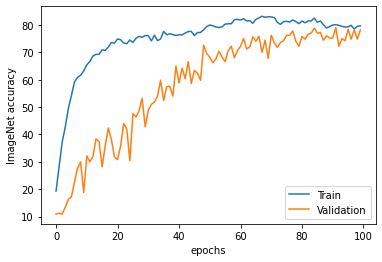

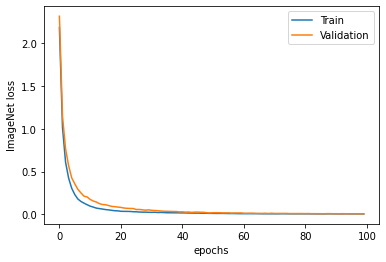

Use `print()` to show values.


In [ ]:
plt.figure()
plt.plot(np.arange(epochCount), trainStats.accuracies.makeNumpyArray(), label:"Train")
plt.plot(np.arange(epochCount), testStats.accuracies.makeNumpyArray(),  label:"Validation")
plt.xlabel("epochs")
plt.ylabel("ImageNet accuracy")
plt.legend(loc:"best")

plt.figure()
plt.plot(np.arange(epochCount), trainStats.averageLosses.makeNumpyArray(), label:"Train")
plt.plot(np.arange(epochCount), testStats.averageLosses.makeNumpyArray(),  label:"Validation")
plt.xlabel("epochs")
plt.ylabel("ImageNet loss")
plt.legend(loc:"best")
plt.show()

In [ ]:
print("Average epoch train time: ", trainStats.avgEpochTrainTime)

Average epoch train time:  633.2480921769144
